In [ ]:
import pandas as pd

# Load the Excel file
file_path = "Kilokari ic1BESS.xlsx"
df = pd.read_excel(file_path)

# Rename columns for clarity (if needed)
df.columns = ["Datetime", "Empty", "Energy"]  # Adjust based on actual structure

# Convert the Datetime column to datetime objects (with error handling)
df["Datetime"] = pd.to_datetime(df["Datetime"], dayfirst=True, errors='coerce')

# Drop rows with invalid/missing datetime values
df = df.dropna(subset=["Datetime"])

# Extract Date and Time
df["Date"] = df["Datetime"].dt.date
df["Time"] = df["Datetime"].dt.time

# Rearranging columns and dropping the placeholder 'Empty' column
df = df[["Datetime", "Date", "Time", "Energy"]]

# Save the result to a new Excel file
df.to_excel("Kilokari_ic1BESS_datetime_separated.xlsx", index=False)

print("✅ Date and Time separated and saved to 'Kilokari_ic1BESS_datetime_separated.xlsx'")

✅ Date and Time separated and saved to 'Kilokari_ic1BESS_datetime_separated.xlsx'


In [ ]:
df.head()

,Datetime,Date,Time,Energy
0,2025-04-15 14:11:28,2025-04-15,14:11:28,0.0
1,2025-04-15 14:14:00,2025-04-15,14:14:00,0.0
2,2025-04-15 14:18:00,2025-04-15,14:18:00,0.0
3,2025-04-15 14:22:00,2025-04-15,14:22:00,0.0
4,2025-04-15 14:26:00,2025-04-15,14:26:00,0.0


In [ ]:
print(df.columns.tolist())

['Datetime', 'Date', 'Time', 'Energy']


In [ ]:
df.tail()

,Datetime,Date,Time,Energy
2502,2025-04-22 13:54:00,2025-04-22,13:54:00,0.0
2503,2025-04-22 13:58:00,2025-04-22,13:58:00,0.0
2504,2025-04-22 14:02:00,2025-04-22,14:02:00,0.0
2505,2025-04-22 14:06:00,2025-04-22,14:06:00,0.0
2506,2025-04-22 14:10:00,2025-04-22,14:10:00,0.0


In [ ]:
# Sort just in case
df = df.sort_values("Datetime").reset_index(drop=True)

# Calculate time difference in hours
df["Time_Diff_hr"] = df["Datetime"].diff().dt.total_seconds() / 3600

# compute ΔEnergy and then derive Active Power (kW)
df["Delta_Energy"] = df["Energy"].diff()
df["Active_Power"] = df["Delta_Energy"] / df["Time_Diff_hr"]

# Drop the first row if needed
df.dropna(inplace=True)

# Classify mode based on Active Power
def classify_mode(power):
    if power > 0:
        return "Discharging"
    elif power < 0:
        return "Charging"
    else:
        return "Idle"

df["Mode"] = df["Active_Power"].apply(classify_mode)

# Calculate duration in seconds
df["Time_Diff_sec"] = df["Datetime"].diff().dt.total_seconds()

# Duration in each mode
mode_duration = df.groupby("Mode")["Time_Diff_sec"].sum()

# Mode transitions
df["Mode_Shift"] = df["Mode"].shift()
transitions = df[df["Mode"] != df["Mode_Shift"]]["Mode"].value_counts()

# Idle time %
total_time = df["Time_Diff_sec"].sum()
idle_time = mode_duration.get("Idle", 0)
idle_percentage = (idle_time / total_time) * 100

# Results
print("Mode Durations (seconds):\n", mode_duration)
print("\nMode Transitions:\n", transitions)
print("\nIdle Time %: {:.2f}%".format(idle_percentage))



Mode Durations (seconds):
 Mode
Charging        36603.0
Discharging     31844.0
Idle           536113.0
Name: Time_Diff_sec, dtype: float64

Mode Transitions:
 Mode
Charging       223
Discharging    222
Idle            26
Name: count, dtype: int64

Idle Time %: 88.68%


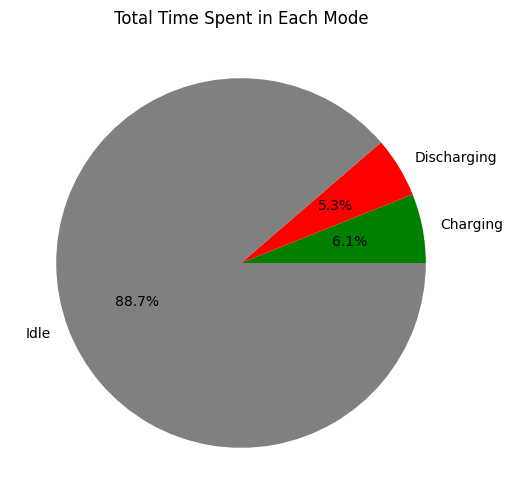

In [ ]:
# Group by Mode and sum durations
mode_durations = df.groupby('Mode')['Time_Diff_sec'].sum()

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(mode_durations, labels=mode_durations.index, autopct='%1.1f%%', colors=['green', 'red', 'gray'])
plt.title('Total Time Spent in Each Mode')
plt.show()

Original DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2506 entries, 2025-04-15 14:14:00 to 2025-04-22 14:10:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           2506 non-null   object 
 1   Time           2506 non-null   object 
 2   Energy         2506 non-null   float64
 3   Time_Diff_hr   2506 non-null   float64
 4   Delta_Energy   2506 non-null   float64
 5   Active_Power   2506 non-null   float64
 6   Mode           2506 non-null   object 
 7   Time_Diff_sec  2505 non-null   float64
 8   Mode_Shift     2505 non-null   object 
dtypes: float64(5), object(4)
memory usage: 195.8+ KB

DataFrame Info after Datetime processing:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2506 entries, 2025-04-15 14:14:00 to 2025-04-22 14:10:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           25

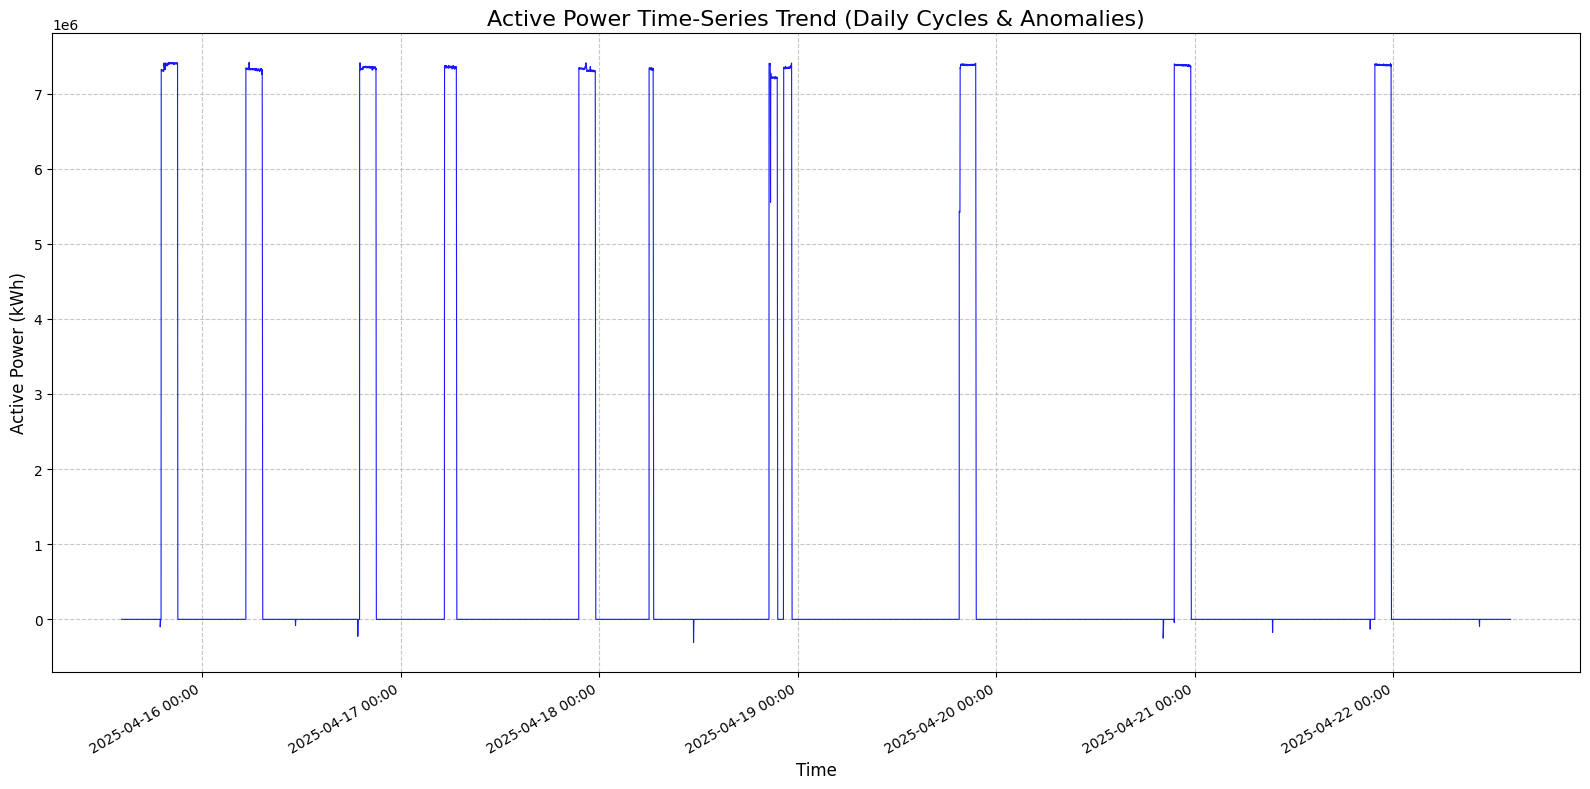

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'df' is already loaded from your Excel file.
# If you haven't loaded it yet, you would typically do something like:
# df = pd.read_excel('your_excel_file.xlsx')
# (Replace 'your_excel_file.xlsx' with the actual name of your file)

# --- Data Preparation ---
# Ensure 'Datetime' is in datetime format and set as index
# The 'Datetime' column is ideal as it contains both date and time.
print("Original DataFrame Info:")
df.info() # Print info to see current data types


print("\nDataFrame Info after Datetime processing:")
df.info() # Print info again to confirm changes
print("\nFirst 5 rows of processed DataFrame (index is Datetime):")
print(df.head())

# --- Time-Series Trend Analysis Plot ---
plt.figure(figsize=(16, 8)) # Increased figure size for better readability

# Plotting Active Power over time using the 'Energy' column
# This assumes 'Energy' represents the active power you want to analyze.
plt.plot(df.index, df['Energy'], color='blue', linewidth=0.8, alpha=0.9)

plt.title('Active Power Time-Series Trend (Daily Cycles & Anomalies)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Active Power (kWh)', fontsize=12) # Label changed to 'Active Power' to match request

plt.grid(True, linestyle='--', alpha=0.7)

# --- Improve X-axis for better daily cycle observation ---
# Use AutoDateLocator for intelligent tick placement
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# Format to show date and time for observing daily cycles
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

# Rotate x-axis labels for better readability if they overlap
plt.gcf().autofmt_xdate()

plt.tight_layout() # Adjusts plot parameters for a tight layout
plt.show()

# --- Further Analysis (beyond simple plotting - for your reference) ---
# To programmatically identify peak times or anomalies, you'd need more advanced techniques.
# For example, to get daily maximum energy (peak consumption):
# daily_peak_energy = df['Energy'].resample('D').max()
# print("\nDaily Peak Energy Consumption:\n", daily_peak_energy)

# For identifying specific anomalies (e.g., sudden drops):
# You would need to define what constitutes an "anomaly" based on your data characteristics.
# A simple approach could be to look for sharp negative changes:
# df['Energy_diff'] = df['Energy'].diff()
# sudden_drops = df[df['Energy_diff'] < -1000000] # Example threshold: change by more than 1,000,000 kWh
# if not sudden_drops.empty:
#     print("\nPotential Sudden Drops (first few rows):\n", sudden_drops[['Energy', 'Energy_diff']].head())
# else:
#     print("\nNo significant sudden drops detected based on example threshold.")

DataFrame with 'Delta_Energy_Calculated' column:
                     Energy  Delta_Energy_Calculated
Datetime                                            
2025-04-15 14:14:00     0.0                      NaN
2025-04-15 14:18:00     0.0                      0.0
2025-04-15 14:22:00     0.0                      0.0
2025-04-15 14:26:00     0.0                      0.0
2025-04-15 14:30:00     0.0                      0.0
2025-04-15 14:34:00     0.0                      0.0
2025-04-15 14:38:00     0.0                      0.0
2025-04-15 14:42:00     0.0                      0.0
2025-04-15 14:46:00     0.0                      0.0
2025-04-15 14:50:00     0.0                      0.0

Descriptive statistics for Delta_Energy_Calculated:
count    2.505000e+03
mean     0.000000e+00
std      6.852243e+05
min     -7.406792e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.435688e+06
Name: Delta_Energy_Calculated, dtype: float64


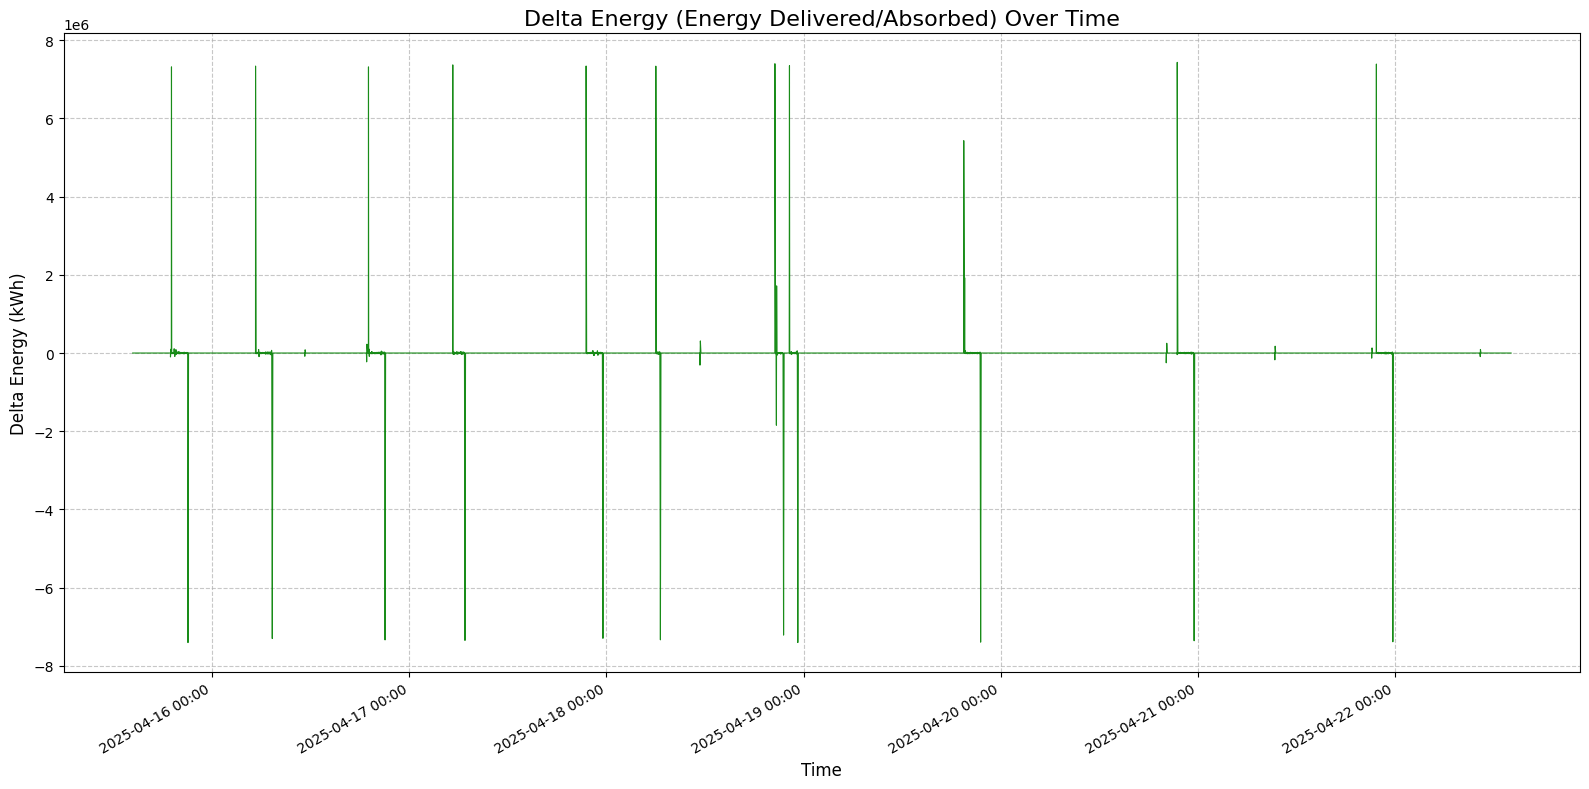

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'df' is already loaded from your Excel file
# and 'Datetime' is already set as the index with datetime objects,
# as per our previous steps.

# If you need to re-load or re-process df from scratch (e.g., in a new session):
# df = pd.read_excel('your_excel_file.xlsx')
# df['Datetime'] = pd.to_datetime(df['Datetime'])
# df = df.sort_values('Datetime')
# df.set_index('Datetime', inplace=True)

# --- Compute Delta Energy ---
# Calculate the difference in the 'Energy' column between consecutive time steps.
# The first value will be NaN (Not a Number) because there's no prior value to subtract.
df['Delta_Energy_Calculated'] = df['Energy'].diff()

# Display the first few rows to show the new 'Delta_Energy_Calculated' column
print("DataFrame with 'Delta_Energy_Calculated' column:")
print(df[['Energy', 'Delta_Energy_Calculated']].head(10)) # Displaying more rows to see some changes

# Display some statistics for Delta_Energy_Calculated
print("\nDescriptive statistics for Delta_Energy_Calculated:")
print(df['Delta_Energy_Calculated'].describe())

# --- Optional: Visualize Delta Energy ---
# This plot will show the rate of energy change over time,
# indicating when energy was delivered (positive Delta) or absorbed (negative Delta, if applicable).
# Given your previous plot shows large positive energy consumption,
# Delta_Energy will also likely be positive for periods of activity.

plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Delta_Energy_Calculated'], color='green', linewidth=0.8, alpha=0.9)

plt.title('Delta Energy (Energy Delivered/Absorbed) Over Time', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Delta Energy (kWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Improve X-axis for better readability
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# --- Interpretation Points (How to analyze the Delta_Energy_Calculated column/plot) ---
# 1. Positive Delta_Energy_Calculated: Indicates energy was delivered/consumed during that interval.
#    In the context of a BESS, if 'Energy' is always positive consumption, then positive delta means energy is flowing into the system (charging or facility consumption).
#    If 'Energy' can be negative (generation/discharge), then positive delta means increase in cumulative energy (more consumption or less generation).
# 2. Negative Delta_Energy_Calculated: Indicates energy was absorbed/generated during that interval (if 'Energy' is bidirectional)
#    Or, if the meter is cumulative and only counts up, a negative delta might indicate a data error, meter reset, or a specific type of BESS operation where it contributes back to the grid.
#    Given your previous plot, significant negative delta values might be less common unless your 'Energy' column represents net grid exchange where negative values imply export.
# 3. Zero Delta_Energy_Calculated: Indicates no change in cumulative energy, meaning the system was idle or not consuming/generating. This will correspond to the long flat lines in your Active_Power plot.
# 4. Peaks in Delta_Energy_Calculated: These represent periods of highest energy delivery or absorption rate. These should correlate directly with the 'on' periods in your Active_Power plot.
# 5. Sum of Delta_Energy_Calculated: The sum of all Delta_Energy_Calculated (exclu

In [ ]:
energy_charged = df[df['Delta_Energy_Calculated'] > 0]['Delta_Energy_Calculated'].sum()
energy_discharged = df[df['Delta_Energy_Calculated'] < 0]['Delta_Energy_Calculated'].abs().sum()

In [ ]:
import pandas as pd
import numpy as np

# Assuming 'df' is already loaded and 'Delta_Energy_Calculated' exists.
# If you are running this in a new session or want to ensure all previous steps are covered:
# 1. Load your Excel file:
# df = pd.read_excel('your_excel_file.xlsx')
#
# 2. Ensure 'Datetime' is processed and set as index:
# df['Datetime'] = pd.to_datetime(df['Datetime'])
# df = df.sort_values('Datetime')
# df.set_index('Datetime', inplace=True)
#
# 3. Compute Delta Energy (Energy Delivered or Absorbed):
# df['Delta_Energy_Calculated'] = df['Energy'].diff() # Or df['Active_Power'].diff() if that's the cumulative one


# --- Step 1: Classify Energy into Charging and Discharging ---
# Based on the sign of Delta_Energy_Calculated:

# Energy Charged: Sum of all positive Delta_Energy_Calculated values.
# This represents energy flowing INTO the BESS.
# We are selecting rows where Delta_Energy_Calculated is greater than 0,
# and then summing those specific Delta_Energy_Calculated values.
energy_charged = df[df['Delta_Energy_Calculated'] > 0]['Delta_Energy_Calculated'].sum()

# Energy Discharged: Sum of the absolute values of all negative Delta_Energy_Calculated values.
# This represents energy flowing OUT of the BESS.
# We are selecting rows where Delta_Energy_Calculated is less than 0,
# taking their absolute values (because discharged energy is conventionally positive),
# and then summing them.
energy_discharged = df[df['Delta_Energy_Calculated'] < 0]['Delta_Energy_Calculated'].abs().sum()

# Energy Idle/No Change: Values where Delta_Energy_Calculated is 0.
# We don't need to sum these for RTE, but it's good to conceptually acknowledge them.
# For example: idle_energy_intervals = df[df['Delta_Energy_Calculated'] == 0]


print(f"--- Classified Energy Totals ---")
print(f"Total Energy Charged (Input to BESS): {energy_charged:,.2f} kWh")
print(f"Total Energy Discharged (Output from BESS): {energy_discharged:,.2f} kWh")


# --- Step 2: Calculate Round-Trip Efficiency (RTE) ---

print(f"\n--- Round-Trip Efficiency Calculation ---")

if energy_charged > 0:
    round_trip_efficiency = (energy_discharged / energy_charged) * 100
    print(f"Round-Trip Efficiency = (Energy Discharged / Energy Charged) * 100")
    print(f"Round-Trip Efficiency = ({energy_discharged:,.2f} kWh / {energy_charged:,.2f} kWh) * 100")
    print(f"Calculated Round-Trip Efficiency (RTE): {round_trip_efficiency:.2f}%")
else:
    print("Cannot calculate Round-Trip Efficiency:")
    print("No energy was recorded as 'charged' (total Energy Charged is zero).")
    print("This might occur if the dataset covers only discharging or idle periods, or if the 'Energy' column doesn't represent net flow.")

# --- Additional Checks/Insights (Optional) ---
# You can add these for more detailed diagnostic messages if needed
# if energy_charged > 0 and energy_discharged == 0:
#     print("\nNote: The system appears to only charge/consume, with no recorded discharge/generation.")
# elif energy_discharged > 0 and energy_charged == 0:
#     print("\nNote: The system appears to only discharge/generate, with no recorded charge/consumption.")
# elif energy_charged > 0 and energy_discharged > 0 and round_trip_efficiency < 50:
#     print("\nWarning: Round-Trip Efficiency is very low. Investigate

--- Classified Energy Totals ---
Total Energy Charged (Input to BESS): 88,123,128.29 kWh
Total Energy Discharged (Output from BESS): 88,123,128.29 kWh

--- Round-Trip Efficiency Calculation ---
Round-Trip Efficiency = (Energy Discharged / Energy Charged) * 100
Round-Trip Efficiency = (88,123,128.29 kWh / 88,123,128.29 kWh) * 100
Calculated Round-Trip Efficiency (RTE): 100.00%


--- Daily Aggregates ---

Total Energy Charged/Discharged Per Day:
             Charged_kWh  Discharged_kWh
Datetime                                
2025-04-15  7.950077e+06    7.950077e+06
2025-04-16  1.604468e+07    1.604468e+07
2025-04-17  1.550084e+07    1.550084e+07
2025-04-18  2.467680e+07    2.467680e+07
2025-04-19  7.764430e+06    7.764430e+06
2025-04-20  8.031287e+06    8.031287e+06
2025-04-21  8.063212e+06    8.063212e+06
2025-04-22  9.180466e+04    9.180466e+04


<Figure size 1400x700 with 0 Axes>

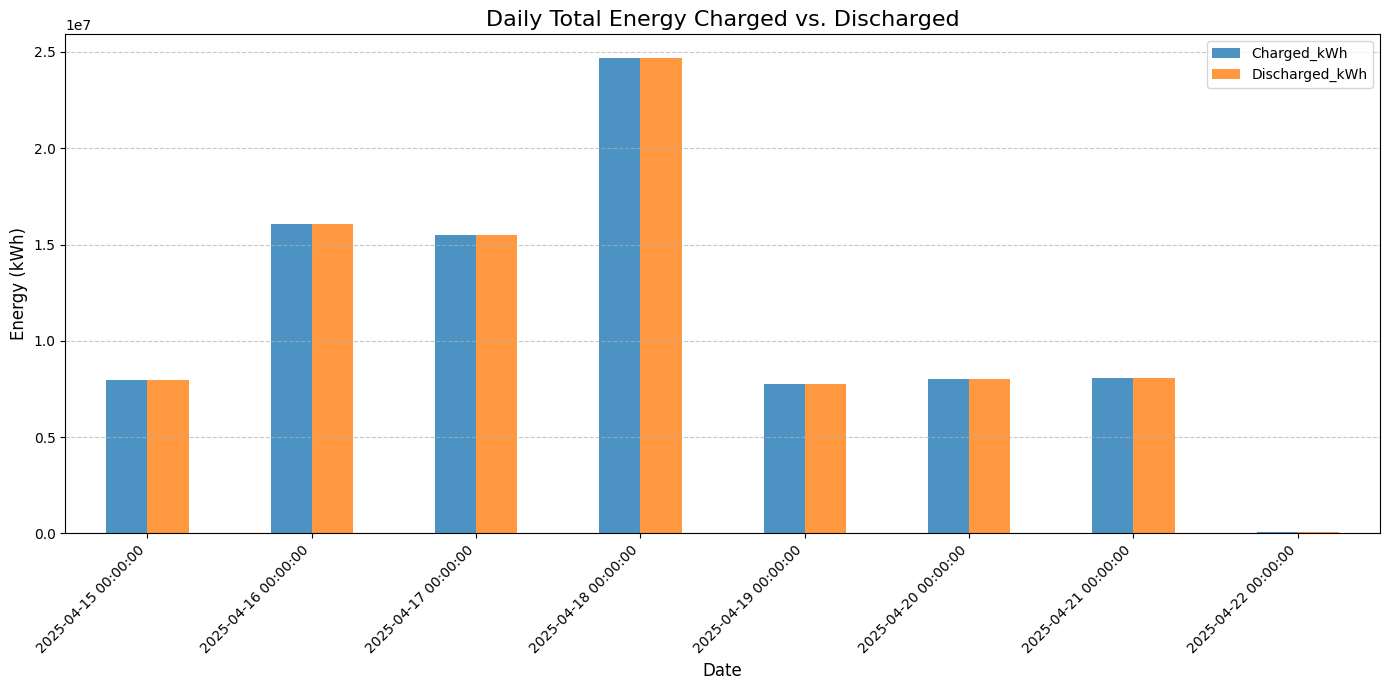


--- Hourly Aggregates ---

Average Active Power (kWh) Per Hour of the Day:
Datetime
0     0.000000e+00
1     0.000000e+00
2     0.000000e+00
3     0.000000e+00
4     0.000000e+00
5     1.067163e+07
6     9.408435e+06
7    -9.762232e+05
8     0.000000e+00
9    -6.134945e+03
10    3.975020e+04
11   -1.760337e+05
12    0.000000e+00
13    0.000000e+00
14    0.000000e+00
15    0.000000e+00
16    0.000000e+00
17    0.000000e+00
18   -5.732564e+05
19    1.317776e+07
20    5.603134e+06
21    1.256857e+07
22    1.637942e+06
23   -3.735219e+06
Name: Active_Power, dtype: float64

Peak Usage Hour (based on average active power): 19:00 - 13,177,760.45 kWh


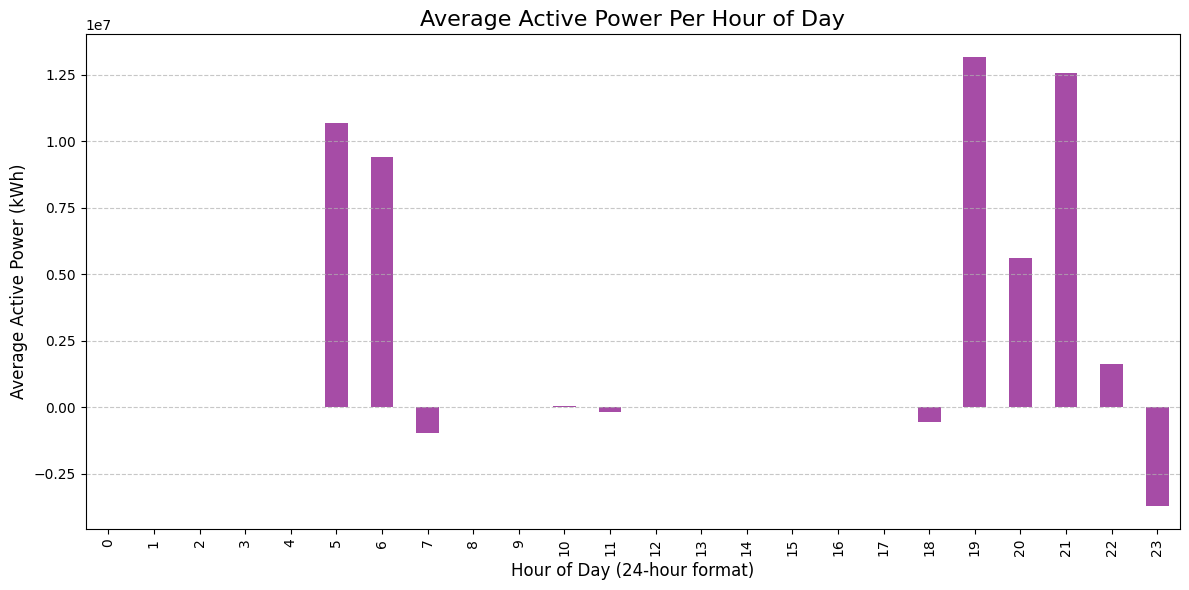

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns # For nicer plots, if available

# Ensure 'df' is loaded and processed with 'Datetime' as index and 'Delta_Energy_Calculated'
# and 'Active_Power' columns.
# (Code for this is in previous responses, assuming it's already run in your environment)

# --- 5. Daily Aggregates ---

print("--- Daily Aggregates ---")

# Resample 'Delta_Energy_Calculated' to daily frequency ('D')
# Sum positive values for daily charged energy
daily_energy_charged = df[df['Delta_Energy_Calculated'] > 0]['Delta_Energy_Calculated'].resample('D').sum()

# Sum absolute negative values for daily discharged energy
daily_energy_discharged = df[df['Delta_Energy_Calculated'] < 0]['Delta_Energy_Calculated'].abs().resample('D').sum()

# Combine into a single DataFrame for easier viewing
daily_summary = pd.DataFrame({
    'Charged_kWh': daily_energy_charged,
    'Discharged_kWh': daily_energy_discharged
})

print("\nTotal Energy Charged/Discharged Per Day:")
print(daily_summary.fillna(0)) # Fill NaN with 0 for days with no activity

# Plotting Daily Charged/Discharged Energy
plt.figure(figsize=(14, 7))
daily_summary.plot(kind='bar', figsize=(14, 7), alpha=0.8)
plt.title('Daily Total Energy Charged vs. Discharged', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Energy (kWh)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# --- 5. Hourly Aggregates ---

print("\n--- Hourly Aggregates ---")

# Group by hour of the day
# Note: For 'average active power per hour', we'll use the 'Active_Power' column directly.
# The 'dt.hour' accessor works on the DatetimeIndex.
hourly_avg_active_power = df.groupby(df.index.hour)['Active_Power'].mean()

print("\nAverage Active Power (kWh) Per Hour of the Day:")
print(hourly_avg_active_power)

# Identify peak usage hours
peak_usage_hour_mean = hourly_avg_active_power.idxmax()
peak_usage_power_mean = hourly_avg_active_power.max()

print(f"\nPeak Usage Hour (based on average active power): {peak_usage_hour_mean:02d}:00 - {peak_usage_power_mean:,.2f} kWh")

# Plotting Average Active Power Per Hour
plt.figure(figsize=(12, 6))
hourly_avg_active_power.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Average Active Power Per Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Average Active Power (kWh)', fontsize=12)
plt.xticks(range(24)) # Ensure all 24 hours are displayed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- Further Detail: Peak Instantaneous Usage Hour ---
# If you want to see the hour with the single highest instantaneous active power reading
# rather than average.
peak_instantaneous_time = df['Active_Power'].idxmax()
peak_instantaneous_power = df['Active_Power'].max()
peak_instantaneous_hour = peak_instantaneous_time.hour